In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
from seaborn import categorical
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import sys
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.preprocessing import Imputer
import os
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
Using TensorFlow backend.


In [2]:
data = pd.read_csv('JustDial_1.csv')
data.head()

,business_id,date,review_id,stars,text,type,user_id,useful,Max_date,Days_to_review,useful_per_day,useful_tag
0,01cEFI5Pq_RyEwM3GSTMpQ,12/31/2016,xWAvEKbLyNmdqdvK32zz5g,4,Good food and able to manage a large group eas...,review,4Nc0DPLqeSZuqvr1gBTy3Q,0,12/31/2016,1,0.0,0
1,53YGfwmbW23JhFiemNeyzQ,12/31/2016,QZlnTcNHKKirdKNfFqbajg,5,"It's been a while since I was in Arizona, but ...",review,7B_LFcB6u1olDoWjd6fSiw,0,12/31/2016,1,0.0,0
2,5kuZhkdpKKu9d_dTflMh4D,12/31/2016,5_XAbm6t-5-k3viakl_TXA,3,"I'll check this place out, despite the whining...",review,vMR4rbIcpQ3d_inCmlLJlQ,0,12/31/2016,1,0.0,0
3,DbS4rMXc19XJJcXVZDhy2w,12/31/2016,225K-qjlBV3kkJxqE2EKeQ,5,Pancit palabok here is best outside of the Phi...,review,XuVeswVBiG7bye8-k731ag,0,12/31/2016,1,0.0,0
4,MXwKBDV24IM_VduC5MWV1g,12/31/2016,fTwKKY6qnO9dEr5AnqIdbg,4,"Once again, family was out to try something ne...",review,UCQNrwN4_hHHTWYa8cqe_Q,0,12/31/2016,1,0.0,0


[Text(0.5, 0, 'stars'),
 Text(1.5, 0, 'useful'),
 Text(2.5, 0, 'Days_to_review'),
 Text(3.5, 0, 'useful_per_day'),
 Text(4.5, 0, 'useful_tag')]

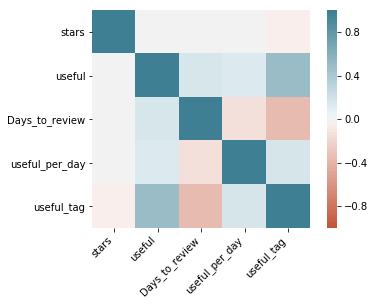

In [3]:
import seaborn as sns
from seaborn import categorical
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right' )

In [4]:
new_data = data[['text','useful_tag','stars']]
new_data['id'] = new_data.index
new_data = new_data[['id', 'text', 'useful_tag','stars']]
new_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,text,useful_tag,stars
0,0,Good food and able to manage a large group eas...,0,4
1,1,"It's been a while since I was in Arizona, but ...",0,5
2,2,"I'll check this place out, despite the whining...",0,3
3,3,Pancit palabok here is best outside of the Phi...,0,5
4,4,"Once again, family was out to try something ne...",0,4


In [5]:
new_data.to_csv('changed_data.csv', encoding='utf-8', index=False)
x=pd.read_csv('changed_data.csv')
x.shape[0]

9860

In [6]:
x

,id,text,useful_tag,stars
0,0,Good food and able to manage a large group eas...,0,4
1,1,"It's been a while since I was in Arizona, but ...",0,5
2,2,"I'll check this place out, despite the whining...",0,3
3,3,Pancit palabok here is best outside of the Phi...,0,5
4,4,"Once again, family was out to try something ne...",0,4
5,5,Everything was nice. The ice cream was delicio...,0,3
6,6,These guys are great!I Even though they speci...,0,5
7,7,They do a great job! My old dry cleaner was al...,0,5
8,8,LollyPOP vintage is pretty sweet! They always ...,0,4
9,9,What a joy to discover Thai Lahna with my frie...,0,5


In [0]:
train, test = np.split(new_data.sample(frac=1), [int(.8*len(new_data))])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [0]:
train['compound_senti']  = 0.000
train['neg_senti']  = 0.000
train['pos_senti']  = 0.000
train['neu_senti']  = 0.000

test['compound_senti']  = 0.000
test['neg_senti']  = 0.000
test['pos_senti']  = 0.000
test['neu_senti']  = 0.000

In [9]:
import nltk
nltk.downloader.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
print(len(train))
print(len(test))

7888
1972


In [0]:
train.to_csv('train.csv',encoding='utf-8', index=False)
test.to_csv('test.csv', encoding='utf-8', index=False)

In [12]:
train.head()

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,333,"After work one night, I had a rediculous cravi...",0,4,0.0,0.0,0.0,0.0
1,6274,I only ask for two things when I'm flying. To ...,0,1,0.0,0.0,0.0,0.0
2,6450,After four years of living in AZ I finally fou...,0,5,0.0,0.0,0.0,0.0
3,1960,"The best fish tacos, period! And I hate chain...",0,5,0.0,0.0,0.0,0.0
4,1722,Good salad options. It is definitely tough to ...,0,3,0.0,0.0,0.0,0.0


In [13]:
print("Number transactions train_data dataset: ", train.shape)
print("Number transactions test_data dataset: ", test.shape)


Number transactions train_data dataset:  (7888, 8)
Number transactions test_data dataset:  (1972, 8)


In [0]:
# Labels are the values we want to predict. Extracting the useful_tag in labels
useful_tag = np.array(x.iloc[:,-1])

# Remove the labels from the features, axis 1 refers to the columns
x1= x.iloc[:, :-1]

#Doing one hot encoding to convert all independent categorical columns into numerical columns
x2 = pd.get_dummies(x1)

# Saving feature names for later use
x2_list = list(x2.columns)

# Convert to numpy array
x2 = np.array(x2)

In [0]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

train_data, test_data,train_labels,test_labels = train_test_split(x2, useful_tag, test_size=0.2, random_state=0)

print("Number transactions train_data dataset: ", train_data.shape)
print("Number transactions train_labels dataset: ", train_labels.shape)
print("Number transactions test_data dataset: ", test_data.shape)
print("Number transactions test_labels dataset: ", test_labels.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Number transactions train_data dataset:  (7888, 9860)
Number transactions train_labels dataset:  (7888,)
Number transactions test_data dataset:  (1972, 9860)
Number transactions test_labels dataset:  (1972,)


In [0]:
print("Before OverSampling, counts of label '0': {}".format(sum(train_labels== 0)))
print("Before OverSampling, counts of label '1': {} ".format(sum(train_labels==1)))



Before OverSampling, counts of label '0': 0
Before OverSampling, counts of label '1': 597 


In [0]:
sm = SMOTE(random_state=2)
train_data, train_labels = sm.fit_sample(train_data, train_labels.ravel())

print('After OverSampling, the shape of train_data: {}'.format(train_data.shape))
print('After OverSampling, the shape of train_labels: {} \n'.format(train_labels.shape))



After OverSampling, the shape of train_data: (13885, 9860)
After OverSampling, the shape of train_labels: (13885,) 



In [0]:
print("After smpling, counts of label '0': {}".format(sum(train_labels== 0)))
print("After smpling, counts of label '1': {} ".format(sum(train_labels==1)))

After smpling, counts of label '0': 0
After smpling, counts of label '1': 2777 


In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

for i in range(0, len(train)):
    train.compound_senti[i] = sia().polarity_scores(train.text[i])['compound']
    train.neu_senti[i] = sia().polarity_scores(train.text[i])['neu']
    train.pos_senti[i] = sia().polarity_scores(train.text[i])['pos']
    train.neg_senti[i] = sia().polarity_scores(train.text[i])['neg']
    #print(i)
   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set 

In [15]:
train.head()

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,333,"After work one night, I had a rediculous cravi...",0,4,0.8240,0.034,0.090,0.876
1,6274,I only ask for two things when I'm flying. To ...,0,1,0.6343,0.094,0.111,0.795
2,6450,After four years of living in AZ I finally fou...,0,5,0.9287,0.030,0.130,0.841
3,1960,"The best fish tacos, period! And I hate chain...",0,5,0.2695,0.239,0.309,0.452
4,1722,Good salad options. It is definitely tough to ...,0,3,0.7430,0.101,0.199,0.700


In [16]:
for i in range(0, len(test)):
    test.compound_senti[i] = sia().polarity_scores(test.text[i])['compound']
    test.neu_senti[i] = sia().polarity_scores(test.text[i])['neu']
    test.pos_senti[i] = sia().polarity_scores(test.text[i])['pos']
    test.neg_senti[i] = sia().polarity_scores(test.text[i])['neg']
    #print(i)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ip

In [17]:
test.head()

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,4342,This place sucks!! I moved to the valley and h...,1,1,-0.4815,0.078,0.054,0.868
1,3910,"You know, I've read some mixed reviews on this...",0,4,0.9032,0.000,0.282,0.718
2,7412,Great library...take your canned food to donat...,0,5,0.9646,0.000,0.502,0.498
3,6570,"Went to Sticklers for the first time today, wi...",0,4,0.9940,0.049,0.226,0.725
4,127,I've never been so impressed with the quality ...,0,2,0.5872,0.098,0.147,0.755


In [0]:
train.to_csv('train.csv',encoding='utf-8', index=False)
test.to_csv('test.csv', encoding='utf-8', index=False)

In [19]:
data1 = pd.read_csv('train.csv')
#data1
data2 = pd.read_csv('test.csv')
data2

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,4342,This place sucks!! I moved to the valley and h...,1,1,-0.4815,0.078,0.054,0.868
1,3910,"You know, I've read some mixed reviews on this...",0,4,0.9032,0.000,0.282,0.718
2,7412,Great library...take your canned food to donat...,0,5,0.9646,0.000,0.502,0.498
3,6570,"Went to Sticklers for the first time today, wi...",0,4,0.9940,0.049,0.226,0.725
4,127,I've never been so impressed with the quality ...,0,2,0.5872,0.098,0.147,0.755
5,9068,Remember how I said that the Trivia was the be...,1,1,0.8662,0.041,0.193,0.767
6,1076,This place is awesome and it replaced Trader J...,0,5,0.8181,0.000,0.148,0.852
7,2047,"Disappointed. I'm from Jersey, everybody in m...",0,2,0.9883,0.031,0.156,0.813
8,303,"Bit over priced, but they're tea is to die for!",0,3,-0.7678,0.385,0.000,0.615
9,1704,This hotel is in a good location for getting t...,0,4,0.9601,0.083,0.160,0.757


In [0]:
def analyze_text(text):
    result = {}
    result['MENTIONS'] = text.count('USER_MENTION')
    result['URLS'] = text.count('URL')
    result['POS_EMOS'] = text.count('EMO_POS')
    result['NEG_EMOS'] = text.count('EMO_NEG')
    text = text.replace('USER_MENTION', '').replace('URL', '')
    words = text.split()
    result['WORDS'] = len(words)
    bigrams = get_bigrams(words)
    result['BIGRAMS'] = len(bigrams)
    return result, words, bigrams


def get_bigrams(text_words):
    bigrams = []
    num_words = len(text_words)
    for i in range(num_words - 1):
        bigrams.append((text_words[i], text_words[i + 1]))
    return bigrams


def get_bigram_freqdist(bigrams):
    freq_dict = {}
    for bigram in bigrams:
        if freq_dict.get(bigram):
            freq_dict[bigram] += 1
        else:
            freq_dict[bigram] = 1
    counter = Counter(freq_dict)
    return counter

In [0]:
import sys
from nltk.stem.porter import PorterStemmer


def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

def is_valid_word(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

def handle_emojis(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    return text

def preprocess_text(text):
    processed_text = []
    # Convert to lower case
    text = text.lower()
    # Replaces URLs with the word URL
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', text)
    # Replace @handle with the word USER_MENTION
    text = re.sub(r'@[\S]+', 'USER_MENTION', text)
    # Replaces #hashtag with hashtag
    text = re.sub(r'#(\S+)', r' \1 ', text)
    # Remove RT (retweet)
    text = re.sub(r'\brt\b', '', text)
    # Replace 2+ dots with space
    text = re.sub(r'\.{2,}', ' ', text)
    # Strip space, " and ' from tweet
    text = text.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    text = handle_emojis(text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    words = text.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            processed_text.append(word)

    return ' '.join(processed_text)

In [22]:
def preprocess_csv(csv_file_name, processed_file_name, test_file=False):
    df = pd.read_csv(csv_file_name)
    
    for i in range(0,len(df)):
        df.text[i] = preprocess_text(df.text[i])
        #print(i)
    
    df.to_csv(processed_file_name,encoding='utf-8', index=False)
    return processed_file_name


if __name__ == '__main__':
   
    use_stemmer = False
    csv_file_name = 'train.csv'
    processed_file_name = 'processed_data.csv'
    preprocess_csv(csv_file_name, processed_file_name, test_file=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [0]:
x = pd.read_csv('processed_data.csv')

In [24]:
x.head()

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,333,after work one night i had a rediculous cravin...,0,4,0.8240,0.034,0.090,0.876
1,6274,i only ask for two things when im flying to la...,0,1,0.6343,0.094,0.111,0.795
2,6450,after four years of living in az i finally fou...,0,5,0.9287,0.030,0.130,0.841
3,1960,the best fish tacos period and i hate chain re...,0,5,0.2695,0.239,0.309,0.452
4,1722,good salad options it is definitely tough to m...,0,3,0.7430,0.101,0.199,0.700


In [25]:
if __name__ == '__main__':
   
    use_stemmer = False
    csv_file_name = 'test.csv'
    processed_file_name = 'data_processed_test.csv'
    preprocess_csv(csv_file_name, processed_file_name, test_file=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [26]:
x= pd.read_csv('processed_data.csv')
x.head()

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,333,after work one night i had a rediculous cravin...,0,4,0.8240,0.034,0.090,0.876
1,6274,i only ask for two things when im flying to la...,0,1,0.6343,0.094,0.111,0.795
2,6450,after four years of living in az i finally fou...,0,5,0.9287,0.030,0.130,0.841
3,1960,the best fish tacos period and i hate chain re...,0,5,0.2695,0.239,0.309,0.452
4,1722,good salad options it is definitely tough to m...,0,3,0.7430,0.101,0.199,0.700


In [27]:
train_df = pd.read_csv('processed_data.csv')
test_df = pd.read_csv('data_processed_test.csv')
train_df.head()
#train_df['usefulness'] = train['useful_tag']
#train_df.columns=['id','text','useful_tag']
#test_df.columns=['id','text']
#test_df = test_df[['id','text','stars', 'compound_senti','neu_senti', 'neg_senti', 'pos_senti', 'useful_tag']]

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,333,after work one night i had a rediculous cravin...,0,4,0.8240,0.034,0.090,0.876
1,6274,i only ask for two things when im flying to la...,0,1,0.6343,0.094,0.111,0.795
2,6450,after four years of living in az i finally fou...,0,5,0.9287,0.030,0.130,0.841
3,1960,the best fish tacos period and i hate chain re...,0,5,0.2695,0.239,0.309,0.452
4,1722,good salad options it is definitely tough to m...,0,3,0.7430,0.101,0.199,0.700


In [28]:
test_df.head()

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti
0,4342,this place sucks i moved to the valley and hav...,1,1,-0.4815,0.078,0.054,0.868
1,3910,you know ive read some mixed reviews on this p...,0,4,0.9032,0.000,0.282,0.718
2,7412,great library take your canned food to donate ...,0,5,0.9646,0.000,0.502,0.498
3,6570,went to sticklers for the first time today wit...,0,4,0.9940,0.049,0.226,0.725
4,127,ive never been so impressed with the quality o...,0,2,0.5872,0.098,0.147,0.755


In [0]:
def feat(data):
    ment=[]
    url=[]
    pe=[]
    ne=[]
    bg=[]
    for i in range(len(data)):
        ment.append(analyze_text(data['text'].values[i])[0]['MENTIONS'])
        url.append(analyze_text(data['text'].values[i])[0]['URLS'])
        pe.append(analyze_text(data['text'].values[i])[0]['POS_EMOS'])
        ne.append(analyze_text(data['text'].values[i])[0]['NEG_EMOS'])
        bg.append(analyze_text(data['text'].values[i])[0]['BIGRAMS'])
    data['ment']=ment
    data['url']=url
    data['pe']=pe
    data['ne']=ne
    data['bg']=bg
    return data

In [0]:
train_df=feat(train_df)
test_df=feat(test_df)


In [31]:
train_df

,id,text,useful_tag,stars,compound_senti,neg_senti,pos_senti,neu_senti,ment,url,pe,ne,bg
0,333,after work one night i had a rediculous cravin...,0,4,0.8240,0.034,0.090,0.876,0,0,0,0,120
1,6274,i only ask for two things when im flying to la...,0,1,0.6343,0.094,0.111,0.795,0,0,0,0,159
2,6450,after four years of living in az i finally fou...,0,5,0.9287,0.030,0.130,0.841,0,0,0,0,116
3,1960,the best fish tacos period and i hate chain re...,0,5,0.2695,0.239,0.309,0.452,0,0,0,0,9
4,1722,good salad options it is definitely tough to m...,0,3,0.7430,0.101,0.199,0.700,0,0,0,0,63
5,7975,i had to do some painting and needed help loca...,0,5,0.9167,0.023,0.176,0.801,0,0,0,0,82
6,2278,if i could eat a southwestern caesar salad onc...,0,3,-0.2846,0.074,0.059,0.866,0,0,0,0,79
7,205,such strange combinations of flavors yet they ...,0,5,0.6700,0.069,0.241,0.690,0,0,0,0,20
8,7480,i was a regular at mias first location in scot...,0,5,0.2354,0.071,0.088,0.841,0,0,0,0,55
9,1694,thanks for the positive reinforcement talk and...,0,5,0.9978,0.036,0.248,0.716,0,0,0,0,299


In [0]:
embed_size = 500 
max_features = 90000 
maxlen = 500 

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df.text))
train_X = tokenizer.texts_to_sequences(train_df.text)
test_X = tokenizer.texts_to_sequences(test_df.text)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
train_X = pd.concat([pd.DataFrame(train_X),train_df[['ment','pe','ne','url','bg','stars', 'compound_senti',
                                                     'neu_senti', 'neg_senti', 'pos_senti']].reset_index(drop=True)],axis=1)
test_X = pd.concat([pd.DataFrame(test_X),test_df[['ment','pe','ne','url','bg','stars', 'compound_senti',
                                                     'neu_senti', 'neg_senti', 'pos_senti']].reset_index(drop=True)],axis=1)

## Get the usefulness values
train_Y = train_df['useful_tag'].values

#train_X = train_df.drop('useful_tag', axis = 1)

train_X,val_X,train_Y, val_Y = train_test_split(train_X,train_Y
                                    , test_size=0.10, random_state=1)

In [33]:
#RF
clf_rf = RandomForestClassifier(n_estimators= 1000, max_depth= 100,max_features = 5,random_state= 11)
clf_rf.fit(train_X,train_Y)
print(accuracy_score(val_Y,clf_rf.predict(val_X)))
confusion_matrix(val_Y,clf_rf.predict(val_X))

0.7769328263624842


array([[613,   1],
       [175,   0]])

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
print(classification_report(val_Y, clf_rf.predict(val_X)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87       614
           1       0.00      0.00      0.00       175

    accuracy                           0.78       789
   macro avg       0.39      0.50      0.44       789
weighted avg       0.61      0.78      0.68       789



In [35]:
#Root Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(val_Y, clf_rf.predict(val_X)))
rms

0.4722998768129374

In [36]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_Y, clf_rf.predict(val_X))

0.22306717363751585

In [37]:
#Mean Square Error
mse = mean_squared_error(val_Y, clf_rf.predict(val_X))
mse

0.22306717363751585

In [38]:
#XGB
clf_xgb = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.05,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)
clf_xgb.fit(train_X,train_Y)
print(accuracy_score(val_Y,clf_xgb.predict(val_X)))
confusion_matrix(val_Y,clf_xgb.predict(val_X))

0.7820025348542459


array([[612,   2],
       [170,   5]])

In [39]:
print(classification_report(val_Y, clf_xgb.predict(val_X)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       614
           1       0.71      0.03      0.05       175

    accuracy                           0.78       789
   macro avg       0.75      0.51      0.47       789
weighted avg       0.77      0.78      0.69       789



In [40]:
#Root Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_xgb = sqrt(mean_squared_error(val_Y, clf_xgb.predict(val_X)))
rmse_xgb

0.4669019866586071

In [41]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae_xgb = mean_absolute_error(val_Y, clf_xgb.predict(val_X))
mae_xgb

0.21799746514575413

In [42]:
#Mean Square Error
mse_xgb = mean_squared_error(val_Y, clf_xgb.predict(val_X))
mse_xgb

0.21799746514575413

In [43]:
#LSTM
def get_model():
    embed_size = 128
    inp = Input(shape=(510, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)    
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = get_model()

model.fit(train_X, train_Y, batch_size=512, epochs=7, validation_data=(val_X, val_Y))

W0807 22:47:01.305758 140001870772096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 22:47:01.358350 140001870772096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 22:47:01.367094 140001870772096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 22:47:01.889769 140001870772096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0807 22:47:01.901359 

Train on 7099 samples, validate on 789 samples
Epoch 1/7
7099/7099 [==============================] - 37s 5ms/step - loss: 0.6470 - acc: 0.7164 - val_loss: 0.5680 - val_acc: 0.7782
Epoch 2/7
7099/7099 [==============================] - 31s 4ms/step - loss: 0.5467 - acc: 0.7736 - val_loss: 0.5282 - val_acc: 0.7782
Epoch 3/7
7099/7099 [==============================] - 31s 4ms/step - loss: 0.5365 - acc: 0.7736 - val_loss: 0.5283 - val_acc: 0.7782
Epoch 4/7
7099/7099 [==============================] - 31s 4ms/step - loss: 0.5338 - acc: 0.7736 - val_loss: 0.5264 - val_acc: 0.7782
Epoch 5/7
7099/7099 [==============================] - 31s 4ms/step - loss: 0.5297 - acc: 0.7736 - val_loss: 0.5252 - val_acc: 0.7782
Epoch 6/7
7099/7099 [==============================] - 31s 4ms/step - loss: 0.5238 - acc: 0.7736 - val_loss: 0.5229 - val_acc: 0.7782
Epoch 7/7
7099/7099 [==============================] - 31s 4ms/step - loss: 0.5134 - acc: 0.7736 - val_loss: 0.5177 - val_acc: 0.7782


In [0]:
pred = model.predict(val_X)

In [0]:
#convert into binary values
for i in range(0,len(pred)):
    if pred[i]>=.5:       # setting threshold to .5
       pred[i]=1
    else:  
       pred[i]=0

In [46]:
accuracy = accuracy_score(val_Y, pred, normalize=True, sample_weight=None)
accuracy

0.7782002534854245

In [47]:
confusion_matrix(val_Y,pred)

array([[614,   0],
       [175,   0]])

In [48]:
print(classification_report(val_Y, pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       614
           1       0.00      0.00      0.00       175

    accuracy                           0.78       789
   macro avg       0.39      0.50      0.44       789
weighted avg       0.61      0.78      0.68       789



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae_lstm = mean_absolute_error(val_Y, pred)
mae_lstm


0.2217997465145754

In [50]:
#Root Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_lstm = sqrt(mean_squared_error(val_Y, pred))
rmse_lstm

0.47095620445491043

In [51]:
#Mean Square Error
mse_lstm = mean_squared_error(val_Y, pred)
mse_lstm

0.2217997465145754

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


#Trying GBM on this dataset
GBM = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.07, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators =30,
              presort='auto', random_state=40, subsample=1.0, verbose=0,
              warm_start=False).fit(train_X, train_Y)

#making predictions
pred_GBM = GBM.predict(val_X)

#Calculating the accuracy

#confusion_matrix(val_Y,pred_GBM)
accuracy_GBM = accuracy_score(val_Y, pred_GBM, normalize=True, sample_weight=None)
accuracy_GBM

0.7769328263624842

In [53]:
confusion_matrix(val_Y,pred_GBM)

array([[612,   2],
       [174,   1]])

In [54]:
print(classification_report(val_Y, pred_GBM))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87       614
           1       0.33      0.01      0.01       175

    accuracy                           0.78       789
   macro avg       0.56      0.50      0.44       789
weighted avg       0.68      0.78      0.68       789



In [55]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae_gbm = mean_absolute_error(val_Y, pred_GBM)
mae_gbm


0.22306717363751585

In [56]:
#Root Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_gbm = sqrt(mean_squared_error(val_Y, pred_GBM))
rmse_gbm

0.4722998768129374

In [57]:
#Mean Square Error
mse_gbm = mean_squared_error(val_Y, pred_GBM)
mse_gbm

0.22306717363751585

In [0]:
import lightgbm as lgb
d_train = lgb.Dataset(train_X, train_Y)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [0]:
#Prediction
y_pred=clf.predict(val_X)
#convert into binary values
for i in range(0,len(y_pred)):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [60]:
#Confusion matrix
confusion_matrix(val_Y,y_pred)

array([[614,   0],
       [175,   0]])

In [61]:
#Accuracy
accuracy_LGBM = accuracy_score(val_Y, y_pred, normalize=True, sample_weight=None)
accuracy_LGBM

0.7782002534854245

In [62]:
print(classification_report(val_Y, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       614
           1       0.00      0.00      0.00       175

    accuracy                           0.78       789
   macro avg       0.39      0.50      0.44       789
weighted avg       0.61      0.78      0.68       789



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae_lbm = mean_absolute_error(val_Y, y_pred)
mae_lbm

0.2217997465145754

In [64]:
#Root Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_lbm = sqrt(mean_squared_error(val_Y, y_pred))
rmse_lbm

0.47095620445491043

In [65]:
#Mean Square Error
mse_lbm = mean_squared_error(val_Y, y_pred)
mse_lbm

0.2217997465145754